In [1]:
# Setup
%matplotlib inline
from sympy import *
import numpy as np
import matplotlib.pyplot as pp
init_printing()

t, m, P, Q, theta = symbols('t m P Q theta', real=true)
EI, GJ, R = symbols('EI GJ R', real=true, positive=true)

# Four-point rim bending test

In a four-point bending test, the rim is supported at 3 and 9 o'clock and loaded at 12 and 6 o'clock with a force $P$. A "dummy torque" $Q$ is applied at each point in the same sense as the rotation of the cross-section. Free-body diagrams of the complete rim and the upper section are shown below.

![schematic1](https://raw.githubusercontent.com/dashdotrobot/rim-testing/master/4-pt-bend-figures-01.png)

The symmetry of the problem gives us the following conditions:

$$V_1 = -V_2$$
$$T_1 = T_2$$
$$M_1 = M_2$$

Sum of forces in the z direction gives

$$\sum F_z = V_1 - V_2 - P=0$$
$$V_1 = \frac{P}{2}$$

Sum of moments at the right end about the y-axis gives

$$\sum_{(2)} M_y = -T_1-T_2+2V_1 R-PR=0$$
$$T_1 = T_2 = 0$$

Sum of moments at the right end about the x-axis gives

$$\sum_{(2)} M_x = M_1+M_2-PR-Q=0$$
$$M_1 = \frac{PR}{2} + \frac{Q}{2}$$

The internal forces can now be determined by making a cut at an arbitrary location $\theta$.

![schematic2](https://raw.githubusercontent.com/dashdotrobot/rim-testing/master/4-pt-bend-figures-02.png)

Sum of forces in the z direction gives

$$\sum F_z = V_1 - V=0$$
$$V = \frac{P}{2}$$

Sum of moments at the left end about the x-axis gives

$$\sum_{(1)} M_x = M_1+T\sin{\theta}-M\cos{\theta}-\frac{PR}{2}\sin{\theta}=0$$

Sum of moments at the left end about the y-axis gives

$$\sum_{(1)} M_y = T\cos{\theta}+M\sin{\theta}+\frac{PR}{2}(1-\cos{\theta})=0$$

### Internal moment and torque from statics

Together, the moment balances above form a simultaneous linear system for $T$ and $M$.

$$T\sin{\theta}-M\cos{\theta}=\frac{PR}{2}\sin{\theta}-\frac{PR}{2}-\frac{Q}{2}$$

$$T\cos{\theta}+M\sin{\theta}+\frac{PR}{2}(1-\cos{\theta})=0$$

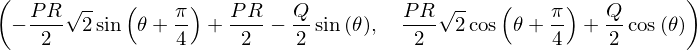

In [2]:
eq1 = t*sin(theta) - m*cos(theta) + P*R/2*(1 - sin(theta)) + Q/2
eq2 = t*cos(theta) + m*sin(theta) + P*R/2*(1 - cos(theta))

s_statics = solve([eq1, eq2], [t, m])

t = s_statics[t]
m = s_statics[m]
t, m

### Get Displacement and rotation from Castigliano's method

The strain energy in the upper half of the rim is given by

$$U = 2\int_0^{\pi/2} \left(\frac{M^2}{2EI} + \frac{T^2}{2GJ} \right) Rd\theta$$

The displacement and rotation at the load point is determined using Castigliano's theorem.

$$u_0 = \frac{\partial U}{\partial P}, \,\,\,\,\,
\phi_0 = \frac{\partial U}{\partial Q}$$

This is the 'balanced' deflection, i.e. the vertical deflections at each load point assuming that the slope $\frac{du}{ds}$ is zero at the supports. In an un-balanced 4-point bend test (three points are constrained and the third is loaded), the displacement will be $2u_0$.

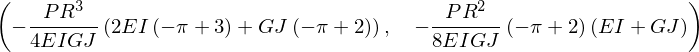

In [3]:
# Strain energy in half the rim
U = R*integrate(m**2/EI + t**2/GJ, (theta, 0, pi/2))

u0 = diff(U, P).subs(Q, 0).simplify()
phi0 = diff(U, Q).subs(Q, 0).simplify()

u0, phi0

## Approximation using Rayleigh-Ritz method

If we assume that the rim adopts a saddle shape, the displacement and rotation are given by

$$u = u_0 \cos{2\theta}, \,\,\,\,\,
\phi = \phi_0 \cos{2\theta}$$

The strain energy is given by

$$U = 4\int_0^{\pi/2} \left(\frac{1}{2}EI \kappa_2^2 + \frac{1}{2}GJ \kappa_3^2\right) Rd\theta$$

where

$$\kappa_2 = u'' + \frac{\phi}{R}$$

$$\kappa_3 = \phi' - \frac{1}{R}u'$$

and $()'$ indicates a derivative with respect to arc length along the beam. The displacement and rotation can then be determined from the Rayleigh-Ritz equations.

$$\frac{\partial U}{\partial u_0} - 4P = 0, \,\,\,\,\,
\frac{\partial U}{\partial \phi_0} - 4Q = 0$$


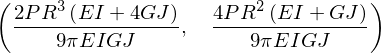

In [4]:
u2, phi2, theta = symbols('u_2 phi_2 theta', real=true)
n = symbols('n', real=true, integer=true, positive=true)

# kinematics
u = u2 * cos(n*theta)
phi = phi2 * cos(n*theta)
k2 = (1/R**2)*diff(u, theta, theta) + phi/R
k3 = (1/R)*diff(phi, theta) - (1/R**2)*diff(u, theta)

# strain energy for 2nd mode
U = 2*integrate((EI*k2**2 + GJ*k3**2)*R, (theta, 0, pi/2))
U = U.subs(n, 2)

# Solve Rayleigh-Ritz equations
rr_soln = solve([diff(U, u2) - 4*P, diff(U, phi2) - 4*Q], [u2, phi2])

u_rr = 2*rr_soln[u2].subs(Q, 0).simplify()
phi_rr = rr_soln[phi2].subs(Q, 0).simplify()

u_rr, phi_rr

In [5]:
# Relative error of Rayleigh-Ritz approximation
print (1 - u_rr / u0).subs([(EI, 1), (GJ, 0.1)]).evalf()
print (1 - phi_rr / phi0).subs([(EI, 1), (GJ, 0.1)]).evalf()

0.00308448422379114
0.00860566976308683


## Measuring $GJ/EI$ with a horizontal bar

Measuring the displacement only yields the combined stiffness. In order to separately determine $EI$ and $GJ$, the rotation must also be measured. This can be done by attaching a rod at the load point which points towards the center of the rim and finding the fixed point along the rod (point which neither rises nor falls when the load is applied)

The location of the fixed point, measuring inward from the load point, is

$$r_f = \frac{u}{\phi}$$

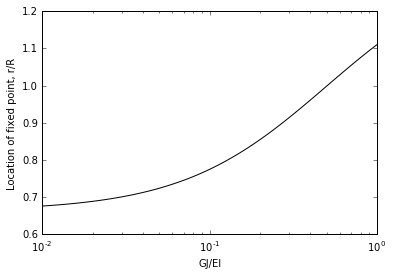

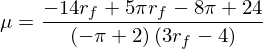

In [11]:
mu = symbols('mu')

u_meas = 2*u0
phi_meas = phi0 + u0/R
r_rot = (u_meas / phi_meas).subs([(R, 1), (EI, 1), (GJ, mu)])

m = np.logspace(-2, 0, 100)

pp.semilogx(m, lambdify(mu, r_rot)(m), 'k')
pp.xlabel('GJ/EI')
pp.ylabel('Location of fixed point, r/R')
pp.show()

# Solve for mu
rf = symbols('r_f', real=true)
Eq(mu, solve(rf - r_rot, mu)[0])

## Measuring $\mu$ and $EI$ from 4-point-bend measurements

In an un-balanced 4-point-bend test, we obtain two quantities:

$$\alpha=P/u$$

$$\beta=\phi/u$$

Note that $u=2u_0$ is the displacement of the load point in the un-balanced test. $\phi$ is measured at one of the pinned supports.

In [7]:
alpha, beta = symbols('alpha beta')

EI_meas = solve(alpha - (P/(2*u0)).subs(GJ, EI*mu), EI)[0]
GJ_meas = solve(alpha - (P/(2*u0)).subs(EI, GJ/mu), GJ)[0]
mu_meas = solve(beta - (phi0/(2*u0)).subs([(EI, 1), (GJ, mu)]), mu)[0]

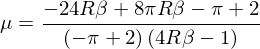

In [8]:
Eq(mu, mu_meas)

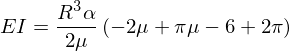

In [9]:
Eq(EI, EI_meas)

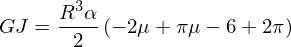

In [10]:
Eq(GJ, GJ_meas)